# LSTMを用いて、人流データを予測する

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## P003

CSVファイルを読み込む

In [5]:
path = '../data/num_file/p003.csv'
p003 = pd.read_csv(path)
print(p003)

           date  hour  bdaddr
0    2022-05-26    14    2680
1    2022-05-26    18   25768
2    2022-05-26    19   29898
3    2022-05-26    20   29425
4    2022-05-26    21   27602
..          ...   ...     ...
690  2022-06-30    23   12735
691  2022-07-01     0    3457
692  2022-07-01     1    2616
693  2022-07-01     2    2296
694  2022-07-01     3    1531

[695 rows x 3 columns]


In [6]:
p003['datetime'] = pd.to_datetime(p003['date'])+pd.to_timedelta(p003['hour'], unit='h')
p003 = p003.drop(['date', 'hour'], axis=1)
print(p003)

     bdaddr            datetime
0      2680 2022-05-26 14:00:00
1     25768 2022-05-26 18:00:00
2     29898 2022-05-26 19:00:00
3     29425 2022-05-26 20:00:00
4     27602 2022-05-26 21:00:00
..      ...                 ...
690   12735 2022-06-30 23:00:00
691    3457 2022-07-01 00:00:00
692    2616 2022-07-01 01:00:00
693    2296 2022-07-01 02:00:00
694    1531 2022-07-01 03:00:00

[695 rows x 2 columns]


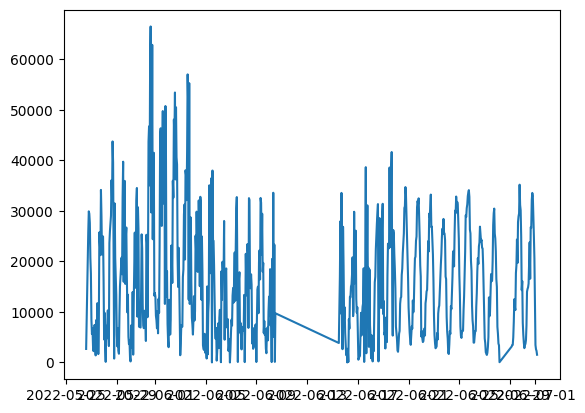

In [7]:
plt.plot(p003['datetime'], p003['bdaddr'])

In [10]:
p003 = p003['bdaddr'].resample('H').mean()
p003.index.freq = 'H'
plt.plot(p003['datetime'], p003['bdaddr'])

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'